## Autoregressive Models with Inflation Data Only

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sml
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import datetime
import shap
from pmdarima import auto_arima

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
# inflation (2011 - Mar 2025)
inflation_data = pd.read_csv('./yoy_inflation_till_March_2025.csv')
inflation_data.head()

,Month,Year-on-Year Change (%)
0,Jan '11,12.079665
1,Feb '11,11.099837
2,Mar '11,12.779128
3,Apr '11,11.291282
4,May '11,12.352128


In [5]:
# Convert string to datetime and then format
def format_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m')
    return date_obj.strftime('%b \'%y')

In [6]:
inflation_data = inflation_data.rename(columns={'Year-on-Year Change (%)': 'Inflation rate'})
inflation_data['Month'] = pd.to_datetime(inflation_data['Month'], format='%b \'%y')
inflation_data.head()

,Month,Inflation rate
0,2011-01-01,12.079665
1,2011-02-01,11.099837
2,2011-03-01,12.779128
3,2011-04-01,11.291282
4,2011-05-01,12.352128


In [7]:
# calculate eval metrics
def calculate_metrics(y_true, y_pred):

    # Convert inputs to numpy arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    r_squared = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2) )
    
    return r_squared, mse, rmse, rmspe, mae, mape, smape



In [8]:
# split the data into train and test sets

split_date = '2017-04-01'

train_data = inflation_data[inflation_data['Month'] < split_date]
test_data = inflation_data[inflation_data['Month'] >= split_date]
# display the first few rows of the train and test DataFrames
display(train_data)
display(test_data)

# print the shape of the train and test data
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

,Month,Inflation rate
0,2011-01-01,12.079665
1,2011-02-01,11.099837
2,2011-03-01,12.779128
3,2011-04-01,11.291282
4,2011-05-01,12.352128
...,...,...
70,2016-11-01,18.476165
71,2016-12-01,18.546964
72,2017-01-01,18.718841
73,2017-02-01,17.780402


,Month,Inflation rate
75,2017-04-01,17.244419
76,2017-05-01,16.251384
77,2017-06-01,16.098398
78,2017-07-01,16.052910
79,2017-08-01,16.011502
...,...,...
166,2024-11-01,34.598334
167,2024-12-01,34.796057
168,2025-01-01,28.871419
169,2025-02-01,27.941947


Train data shape: (75, 2)
Test data shape: (96, 2)


In [9]:
y_train = train_data['Inflation rate']
print(f"y_train shape: {y_train.shape}")

y_test = test_data['Inflation rate']
print(f"y_test shape: {y_test.shape}")

y_train shape: (75,)
y_test shape: (96,)


### Pre-modeling analysis

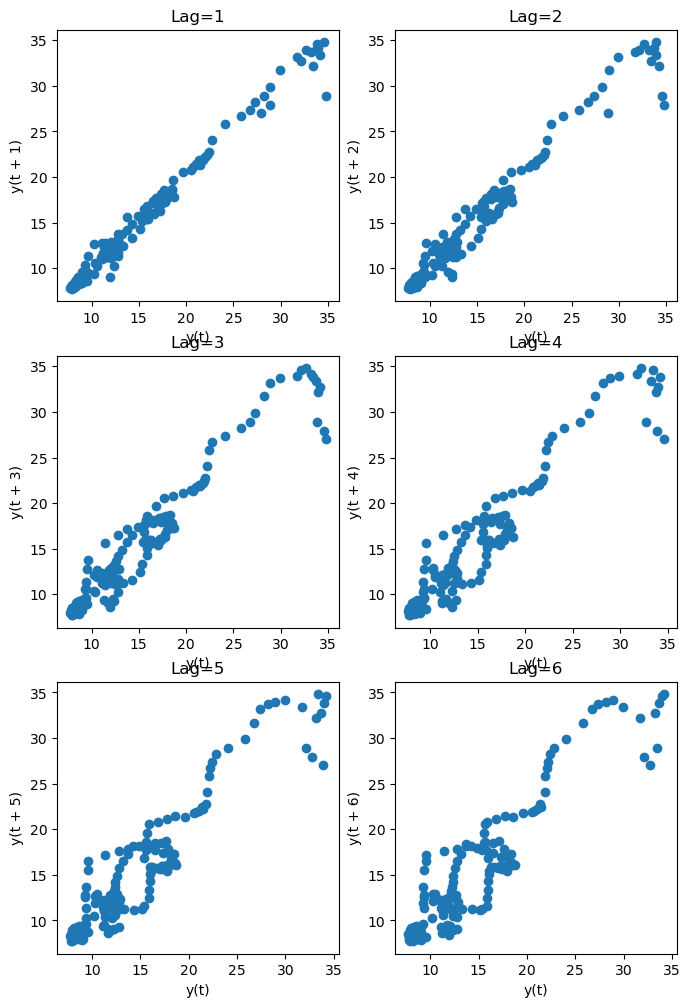

In [10]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('NG Inflation Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(inflation_data['Inflation rate'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
plt.savefig("auto_correlation_lag_plot.png")
plt.show()


Interpretation Summary:
The time series is not random.

There is strong short-term autocorrelation, especially at Lag=1.

The decay of correlation suggests the presence of trend or long-memory behavior.

Non-linearity in higher lags implies the data may benefit from non-linear modeling techniques (e.g., ARIMA with transformations, or machine learning models).

**Since the Autocorrelation plots are not fully linear, we will let pdarima determine the proper lag term to use**

In [11]:
# Fit AR model with d=1 but allowing ARIMA model to explore for p and q values to is best suited

ar_baseline = auto_arima(
                        y_train, 
                        # d=n_diffs, 
                        d=2,
                        seasonal=False, 
                        stepwise=True,
                        suppress_warnings=True, 
                        error_action="ignore", 
                        max_p=36,
                        max_order=None,
                        information_criterion='aic',
                        # information_criterion='bic',
                        trace=True
                    )

print(f'(p, d, q): {ar_baseline.order}')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=228.441, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=191.127, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=226.443, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=189.398, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=186.983, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=185.088, Time=0.03 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=186.569, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=186.773, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=183.107, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=185.023, Time=0.02 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=184.579, Time=0.05 se

In [12]:
model = ar_baseline  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

# Calculate metrics for the naive baseline
metrics_test_ar_baseline = calculate_metrics(y_test, forecasts)

# Create a DataFrame to store the metrics
metrics_test_ar_baseline_df = pd.DataFrame({
    'Model': ['AR Baseline'],
    'R-squared': [metrics_test_ar_baseline[0]],
    'MSE': [metrics_test_ar_baseline[1]],
    'RMSE': [metrics_test_ar_baseline[2]],
    'RMSPE': [metrics_test_ar_baseline[3]],
    'MAE': [metrics_test_ar_baseline[4]],
    'MAPE': [metrics_test_ar_baseline[-2]],
    'SMAPE': [metrics_test_ar_baseline[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_baseline_df = metrics_test_ar_baseline_df.round(2)
display(metrics_test_ar_baseline_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline,0.99,0.65,0.81,3.27,0.42,2.08,2.06


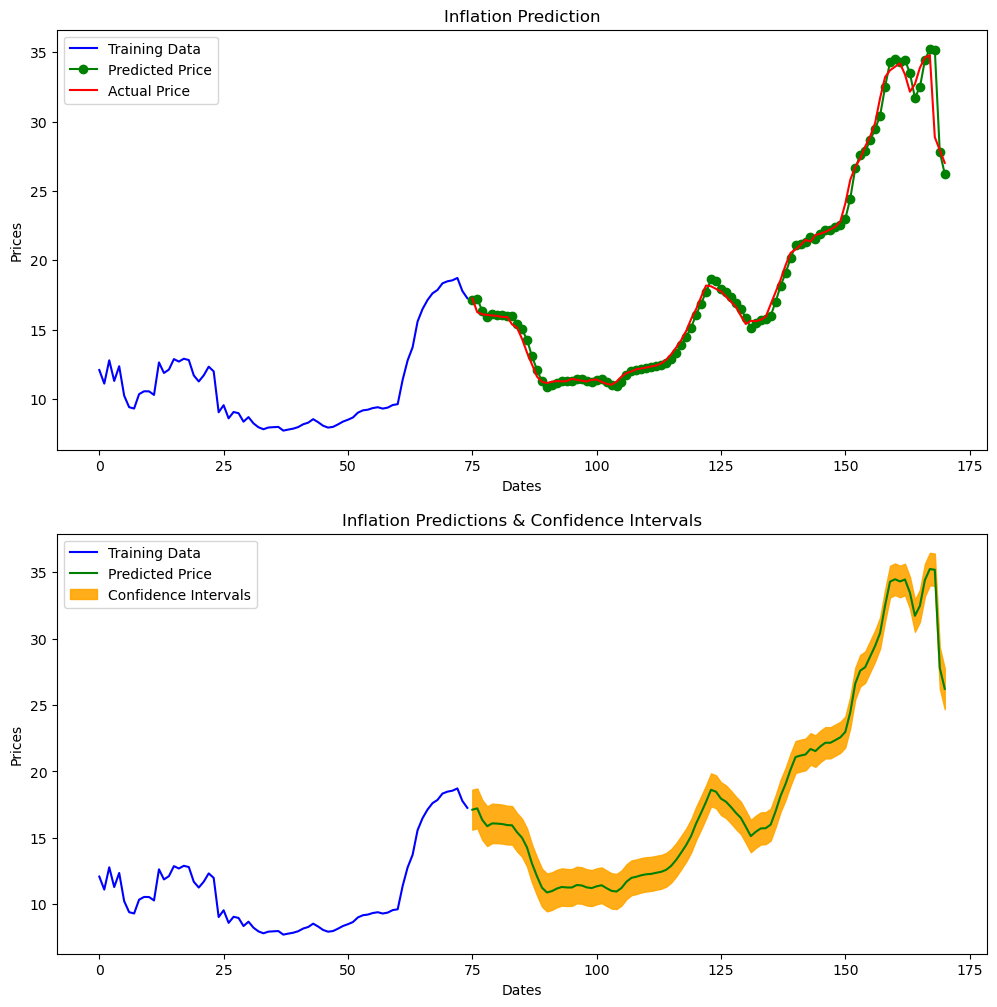

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Inflation Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Inflation Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

In [14]:
# PERFORMANCE BEFORE REBASE (Jan 2024 - Dec 2024)
# first 12 months in the test set

# Get the first 12 months of the test set
metrics_test_ar_baseline_before_rebase = calculate_metrics(y_test[:12], forecasts[:12])

# Create a DataFrame to store the metrics
metrics_test_ar_baseline_before_rebase_df = pd.DataFrame({
    'Model': ['AR Baseline (Test Before Rebase)'],
    'R-squared': [metrics_test_ar_baseline_before_rebase[0]],
    'MSE': [metrics_test_ar_baseline_before_rebase[1]],
    'RMSE': [metrics_test_ar_baseline_before_rebase[2]],
    'RMSPE': [metrics_test_ar_baseline_before_rebase[3]],
    'MAE': [metrics_test_ar_baseline_before_rebase[4]],
    'MAPE': [metrics_test_ar_baseline_before_rebase[-2]],
    'SMAPE': [metrics_test_ar_baseline_before_rebase[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_baseline_before_rebase_df = metrics_test_ar_baseline_before_rebase_df.round(2)
display(metrics_test_ar_baseline_before_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline (Test Before Rebase),0.75,0.24,0.48,3.29,0.36,2.41,2.36


In [15]:
# PERFORMANCE AFTER REBASE
# calculate the metrics for each model for y_test and y_pred last 3 months (Jan - Mar 2025)

metrics_test_ar_baseline_after_rebase = calculate_metrics(y_test[-3:], forecasts[-3:])


# Create a DataFrame to store the metrics
metrics_test_ar_baseline_after_rebase_df = pd.DataFrame({
    'Model': ['AR Baseline (Test Before Rebase)'],
    'R-squared': [metrics_test_ar_baseline_after_rebase[0]],
    'MSE': [metrics_test_ar_baseline_after_rebase[1]],
    'RMSE': [metrics_test_ar_baseline_after_rebase[2]],
    'RMSPE': [metrics_test_ar_baseline_after_rebase[3]],
    'MAE': [metrics_test_ar_baseline_after_rebase[4]],
    'MAPE': [metrics_test_ar_baseline_after_rebase[-2]],
    'SMAPE': [metrics_test_ar_baseline_after_rebase[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_baseline_after_rebase_df = metrics_test_ar_baseline_after_rebase_df.round(2)
display(metrics_test_ar_baseline_after_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline (Test Before Rebase),-22.63,13.52,3.68,12.75,2.42,8.45,7.75


In [16]:
list_of_dfs = [
    metrics_test_ar_baseline_df,
    metrics_test_ar_baseline_before_rebase_df,
    metrics_test_ar_baseline_after_rebase_df,
]

result_df = pd.concat(list_of_dfs, axis=0)
result_df

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline,0.99,0.65,0.81,3.27,0.42,2.08,2.06
0,AR Baseline (Test Before Rebase),0.75,0.24,0.48,3.29,0.36,2.41,2.36
0,AR Baseline (Test Before Rebase),-22.63,13.52,3.68,12.75,2.42,8.45,7.75


In [17]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 2


### Since differencing does not change, we can stick with this split.

# TODO: 

- Add Google Trends Data as exogenous information to handle the rebase shock
    - Preprocess first